# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../rnn/sliding_windows_google.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow import keras

from keras.callbacks import CSVLogger

In [2]:
# Total time points
N = 3000  

t= np.arange(0,N)
x= (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
df.head()

,Data
0,0.181252
1,-0.516920
2,0.030039
3,0.170186
4,0.176288


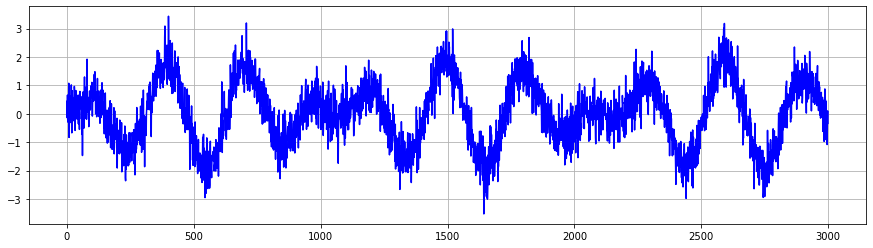

In [225]:
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True)
plt.show()

In [226]:
values = df.values
Tp1 = int(N*0.2) # Tp1 sería el tamaño de TRAIN
Tt = int(N*0.2) # Tt sería el tamaño de TEST
train = values[0:Tp1 ,:]
test = values[Tp1:Tp1+Tt,:]

In [227]:
print("Train data length:", train.shape) # El train son los primeros 600 valores
print("Test data length:", test.shape) # El test son los segundos 600 valores

Train data length: (600, 1)
Test data length: (600, 1)


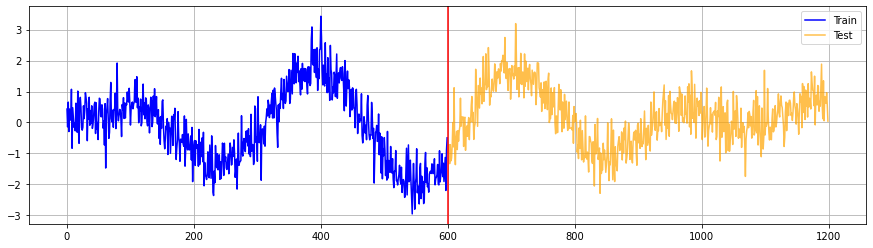

In [228]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp1],train,c='blue')
plt.plot(index[Tp1:Tp1+Tt],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp1], c="r")
plt.grid(True)
plt.show()

In [229]:
step = 4
train1 = np.append(train, np.repeat(train[-1], step))
test1 = np.append(test, np.repeat(test[-1], step))

In [230]:
print("train1.shape :", train1.shape)
print("test1.shape:", test1.shape)

train1.shape : (604,)
test1.shape: (604,)


In [231]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [232]:
trainX_1, trainY_1 = convertToMatrix(train1, step)
testX_1,testY_1 = convertToMatrix(test1,step)

print("trainX_1.shape :", trainX_1.shape)
print("trainY_1.shape:", trainY_1.shape)
print('---')
print("testX_1.shape :", testX_1.shape)
print("testY_1.shape:", testY_1.shape)

trainX_1.shape : (600, 4)
trainY_1.shape: (600,)
---
testX_1.shape : (600, 4)
testY_1.shape: (600,)


## Para entrenar el modelo necesito que los datos tengan la siguiente dimension: (600, 1, 4)

In [233]:
trainX_1_rs = np.reshape(trainX_1, (trainX_1.shape[0], 1, trainX_1.shape[1]))
testX_1_rs = np.reshape(testX_1, (testX_1.shape[0], 1, testX_1.shape[1]))

print("trainX_1_rs.shape :", trainX_1_rs.shape)
print("testX_1_rs.shape :", testX_1_rs.shape)

trainX_1_rs.shape : (600, 1, 4)
testX_1_rs.shape : (600, 1, 4)


In [234]:
def build_rnn_LSTM(num_units, embedding, num_dense, lr):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1, embedding), activation = 'relu'))
    model.add(Dense(units=num_dense, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = RMSprop(learning_rate= lr), metrics= ['mse'])

    return model

In [235]:
model1 = build_rnn_LSTM(128, 4, 32, 0.001)
model1.save("model1_sin_entrenar.h5")

In [236]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


### Una clase callback para mostrar un mensaje cada 50 épocas

In [237]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

## Entrenando el modelo

### La idea es ir pasando los datos poco a poco. Usando batch_size = 16, los datos tendrían la siguiente forma:

### (16, 1, 4)

### Son 16 trozos de 1 fila con 4 datos


In [238]:
batch_size = 16
num_epochs = 1000

In [239]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log', separator=',', append=False)

model1.fit(trainX_1_rs, trainY_1,
           epochs = num_epochs,
           batch_size = batch_size,
           callbacks = [MyCallback(), csv_logger],
           verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [ ]:
'''
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training.log', separator=',', append=False)
model.fit(X_train, Y_train, callbacks=[csv_logger])
'''

In [241]:
model1.save('model1_entrenado.h5')

## Graficando loss

In [216]:
model1 = keras.models.load_model('model1_entrenado.h5')

In [ ]:
modelooo

In [248]:
model1_loss_mse = pd.read_csv('training.log', sep=',', engine='python')
model1_loss_mse

,epoch,loss,mse
0,0,0.737757,0.737757
1,1,0.321123,0.321123
2,2,0.309110,0.309110
3,3,0.307374,0.307374
4,4,0.305225,0.305225
...,...,...,...
995,995,0.073886,0.073886
996,996,0.071522,0.071522
997,997,0.078060,0.078060
998,998,0.075840,0.075840


In [ ]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model1.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

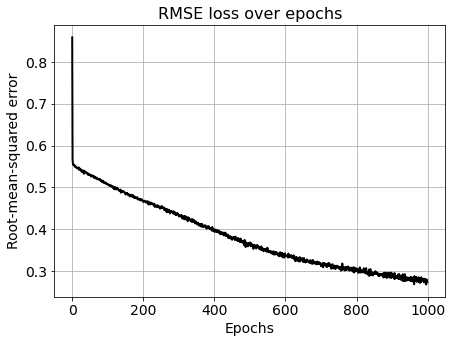

In [247]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model1.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

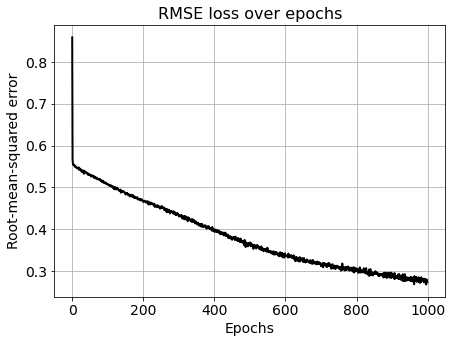

In [249]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model1_loss_mse['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Predicciones

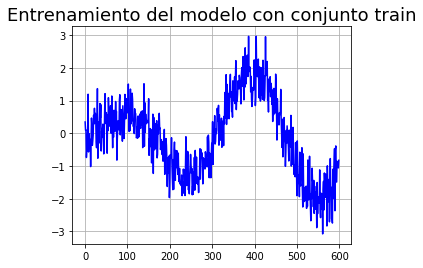

In [79]:
plt.figure(figsize=(5,4))
plt.title("Entrenamiento del modelo con conjunto train",fontsize=18)
plt.plot(trainX_1_rs[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [76]:
train_1_predict = model1.predict(trainX_1_rs)
test_1_predict = model1.predict(testX_1_rs)
prediccion_1 = np.concatenate((train_1_predict, test_1_predict), axis=0)

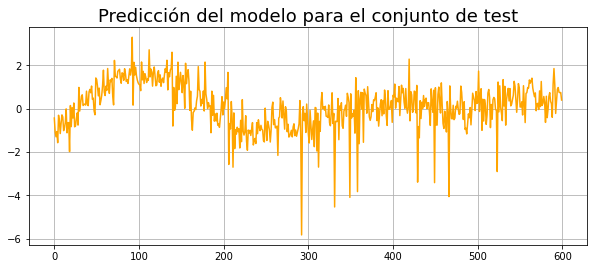

In [78]:
plt.figure(figsize=(10,4))
plt.title("Predicción del modelo para el conjunto de test",fontsize=18)
plt.plot(test_1_predict,c='orange')
plt.grid(True)
plt.show()

## Comparando

In [84]:
df[0:Tp1+Tt]

,Data
0,0.344905
1,0.090479
2,0.099887
3,-0.741132
4,-0.505861
...,...
1195,0.304290
1196,0.913641
1197,1.431145
1198,0.133353


In [86]:
index[0:Tp1+Tt]

array([   0,    1,    2, ..., 1197, 1198, 1199], dtype=int64)

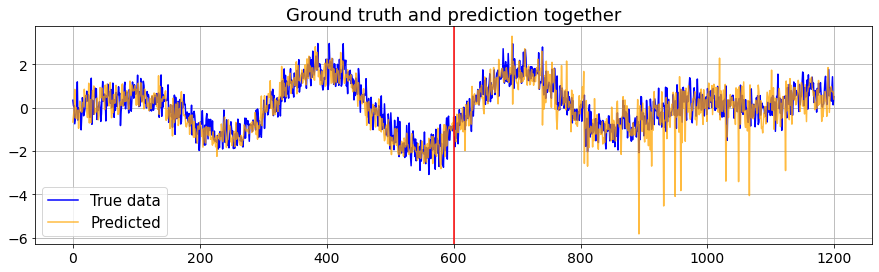

In [88]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index[0:Tp1+Tt],df[0:Tp1+Tt],c='blue')
plt.plot(index[0:Tp1+Tt],prediccion_1,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp1], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Distribución del error

In [157]:
prediccion_1[Tp1::].shape

(600, 1)

In [158]:
error1 = prediccion_1[Tp1::]-df[Tp1:Tp1+Tt]
error1 = np.array(error1).ravel()

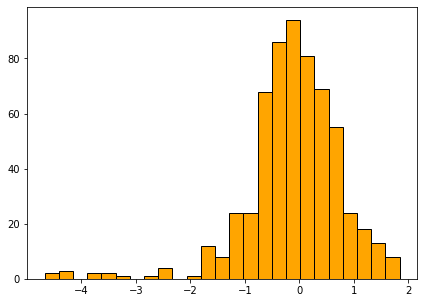

In [159]:
plt.figure(figsize=(7,5))
plt.hist(error1,bins=25,edgecolor='k',color='orange')
plt.show()

## Acá empezaría el segundo entrenamiento

In [90]:
values = df.values
Tp2 = int(N*0.4) # Lo que cambia es que acá se toma el 40% del total. En el primer entrenamiento era solo el 20%
Tt = int(N*0.2) # Tt sería el tamaño de TEST --> este no varía
train = values[0:Tp2 ,:]
test = values[Tp2:Tp2+Tt,:]

In [91]:
print("Train data length:", train.shape) # El train son los primeros 1200 valores
print("Test data length:", test.shape) # El test son los terceros 600 valores

Train data length: (1200, 1)
Test data length: (600, 1)


## VOY A HACER UN BUCLE PARA HACER TODOS LOS ENTRENAMIENTOS

In [3]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

i = 1
Tp = 600 Tt = 600
train.shape = (600, 1)
test.shape = (600, 1)


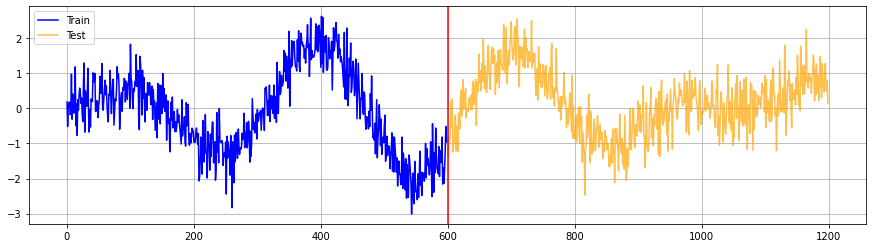


AGREGANDO LOS VALORES DE STEP A train Y test

train.shape = (604,)
test.shape = (604,)

CONVIRTIENDO A ARRAY MULTIDIMENSIONAL CON EL VALOR DE STEP

trainX.shape = (600, 4)      trainY.shape = (600,)
testX.shape = (600, 4)      testY.shape = (600,)

REDIMENSIONANDO DATOS PARA INGRESARLOS AL MODELO --> Para que tenga la forma ("valores", 1, "step")

trainX.shape : (600, 1, 4)
testX.shape : (600, 1, 4)

SE INGRESAN TODOS LOS VALORES A SU CORRESPONDIENTE LISTA. A ESTOS VALORES SE INGRESA CON EL (NÚMERO DE ENTRENAMIENTO -1) 

trainX_list[0].shape =  (600, 1, 4)
trainY_list[0].shape =  (600,)
testX_list[0].shape =  (600, 1, 4)
testY_list[0].shape =  (600,)


i = 2
Tp = 1200 Tt = 600
train.shape = (1200, 1)
test.shape = (600, 1)


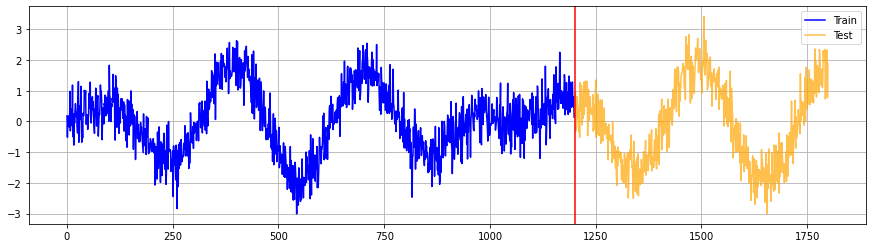


AGREGANDO LOS VALORES DE STEP A train Y test

train.shape = (1204,)
test.shape = (604,)

CONVIRTIENDO A ARRAY MULTIDIMENSIONAL CON EL VALOR DE STEP

trainX.shape = (1200, 4)      trainY.shape = (1200,)
testX.shape = (600, 4)      testY.shape = (600,)

REDIMENSIONANDO DATOS PARA INGRESARLOS AL MODELO --> Para que tenga la forma ("valores", 1, "step")

trainX.shape : (1200, 1, 4)
testX.shape : (600, 1, 4)

SE INGRESAN TODOS LOS VALORES A SU CORRESPONDIENTE LISTA. A ESTOS VALORES SE INGRESA CON EL (NÚMERO DE ENTRENAMIENTO -1) 

trainX_list[1].shape =  (1200, 1, 4)
trainY_list[1].shape =  (1200,)
testX_list[1].shape =  (600, 1, 4)
testY_list[1].shape =  (600,)


i = 3
Tp = 1800 Tt = 600
train.shape = (1800, 1)
test.shape = (600, 1)


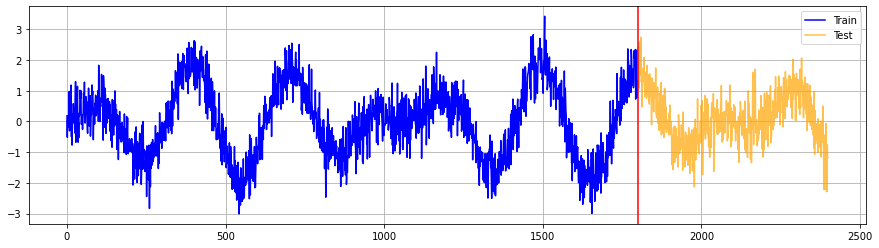


AGREGANDO LOS VALORES DE STEP A train Y test

train.shape = (1804,)
test.shape = (604,)

CONVIRTIENDO A ARRAY MULTIDIMENSIONAL CON EL VALOR DE STEP

trainX.shape = (1800, 4)      trainY.shape = (1800,)
testX.shape = (600, 4)      testY.shape = (600,)

REDIMENSIONANDO DATOS PARA INGRESARLOS AL MODELO --> Para que tenga la forma ("valores", 1, "step")

trainX.shape : (1800, 1, 4)
testX.shape : (600, 1, 4)

SE INGRESAN TODOS LOS VALORES A SU CORRESPONDIENTE LISTA. A ESTOS VALORES SE INGRESA CON EL (NÚMERO DE ENTRENAMIENTO -1) 

trainX_list[2].shape =  (1800, 1, 4)
trainY_list[2].shape =  (1800,)
testX_list[2].shape =  (600, 1, 4)
testY_list[2].shape =  (600,)


i = 4
Tp = 2400 Tt = 600
train.shape = (2400, 1)
test.shape = (600, 1)


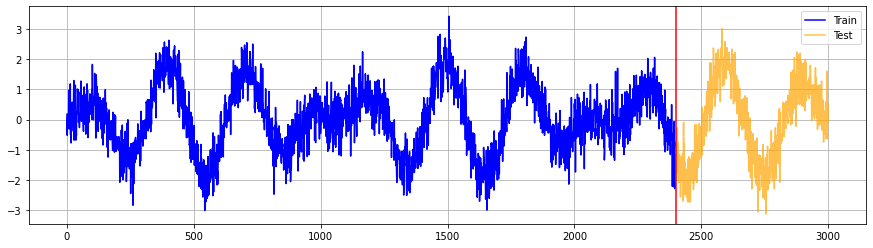


AGREGANDO LOS VALORES DE STEP A train Y test

train.shape = (2404,)
test.shape = (604,)

CONVIRTIENDO A ARRAY MULTIDIMENSIONAL CON EL VALOR DE STEP

trainX.shape = (2400, 4)      trainY.shape = (2400,)
testX.shape = (600, 4)      testY.shape = (600,)

REDIMENSIONANDO DATOS PARA INGRESARLOS AL MODELO --> Para que tenga la forma ("valores", 1, "step")

trainX.shape : (2400, 1, 4)
testX.shape : (600, 1, 4)

SE INGRESAN TODOS LOS VALORES A SU CORRESPONDIENTE LISTA. A ESTOS VALORES SE INGRESA CON EL (NÚMERO DE ENTRENAMIENTO -1) 

trainX_list[3].shape =  (2400, 1, 4)
trainY_list[3].shape =  (2400,)
testX_list[3].shape =  (600, 1, 4)
testY_list[3].shape =  (600,)




In [4]:
trainX_list = []
trainY_list = []
testX_list = []
testY_list = []
values = df.values
cantidad_entrenamientos = 4
for i in range(1,cantidad_entrenamientos+1): # --> Representa la cantidad de entrenamientos que se van a hacer. En este caso son 4.
    print('i =', i)
    Tp = int(N * i/(cantidad_entrenamientos+1))
    Tt = int(N * 1/(cantidad_entrenamientos+1))
    print ('Tp =', Tp , 'Tt =', Tt)
    train = values[0:Tp, :]
    test = values[Tp:Tp+Tt, :]
    
    print('train.shape =', train.shape)
    print('test.shape =', test.shape)
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.plot(index[0:Tp],train,c='blue')
    plt.plot(index[Tp:Tp+Tt],test,c='orange',alpha=0.7)
    plt.legend(['Train','Test'])
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.show()
    print('\nAGREGANDO LOS VALORES DE STEP A train Y test\n')
    step = 4
    train = np.append(train, np.repeat(train[-1], step))
    test = np.append(test, np.repeat(test[-1], step))
    print('train.shape =', train.shape)
    print('test.shape =', test.shape)
    
    print('\nCONVIRTIENDO A ARRAY MULTIDIMENSIONAL CON EL VALOR DE STEP\n')
    trainX, trainY = convertToMatrix(train, step)
    testX,testY = convertToMatrix(test,step)

    print("trainX.shape =", trainX.shape, "     trainY.shape =", trainY.shape)
    print("testX.shape =", testX.shape, "     testY.shape =", testY.shape)
    
    print('\nREDIMENSIONANDO DATOS PARA INGRESARLOS AL MODELO --> Para que tenga la forma ("valores", 1, "step")\n')
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    print("trainX.shape :", trainX.shape)
    print("testX.shape :", testX.shape)

    print('\nSE INGRESAN TODOS LOS VALORES A SU CORRESPONDIENTE LISTA. A ESTOS VALORES SE INGRESA CON EL (NÚMERO DE ENTRENAMIENTO -1) \n')
    trainX_list.append(trainX)
    trainY_list.append(trainY)
    testX_list.append(testX)
    testY_list.append(testY)
    print('trainX_list[' + str(i-1) + '].shape = ', trainX_list[i-1].shape)
    print('trainY_list[' + str(i-1) + '].shape = ', trainY_list[i-1].shape)
    print('testX_list[' + str(i-1) + '].shape = ', testX_list[i-1].shape)
    print('testY_list[' + str(i-1) + '].shape = ', testY_list[i-1].shape)
    print('\n==================================================================\n')

### Una clase callback para mostrar un mensaje cada 50 épocas


In [5]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

In [6]:
def build_rnn_LSTM(num_units, embedding, num_dense, lr):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(LSTM(units=num_units, input_shape=(1, embedding), activation = 'relu'))
    model.add(Dense(units=num_dense, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = RMSprop(learning_rate= lr), metrics= ['mse'])

    return model

## Construyendo modelo

In [7]:
model = build_rnn_LSTM(128, step, 32, 0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 72,257
Trainable params: 72,257
Non-trainable params: 0
_________________________________________________________________


## Entrenando modelo con el primer conjunto TRAIN

### La idea es ir pasando los datos poco a poco. Usando batch_size = 16, los datos tendrían la siguiente forma:

### (16, 1, 4)

### Son 16 trozos de 1 fila con 4 datos

In [8]:
batch_size = 16
num_epochs = 1000

# DESDE ACA HASTA CUANDO AVISE SEVELA DIFERENCIA ENTRE loss DE MODELO GUARDADO/CARGADO con CSVLogger y el que se usa directamente

In [10]:
# NOOOOOOOO EJECUTARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

# Entrenando con los primeros valores
csv_logger = CSVLogger('primer_entrenamiento.log', separator=',', append=False)

model.fit(trainX_list[0], trainY_list[0],
          epochs= num_epochs,
          batch_size = batch_size,
          callbacks= [MyCallback(), csv_logger],
          verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [9]:
model.fit(trainX_list[0], trainY_list[0],
          epochs= num_epochs,
          batch_size = batch_size,
          callbacks= [MyCallback()],
          verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [10]:
model.save('model_primer_entrenamiento.h5')

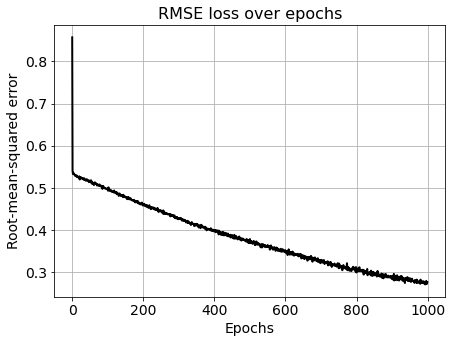

In [11]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [20]:
''' model.history.history['loss'][0:3] '''

[0.8315315246582031, 0.3256387710571289, 0.29003220796585083]

In [22]:
''' modelpepe_loss_mse '''

,epoch,loss,mse
0,0,0.737757,0.737757
1,1,0.321123,0.321123
2,2,0.309110,0.309110
3,3,0.307374,0.307374
4,4,0.305225,0.305225
...,...,...,...
995,995,0.073886,0.073886
996,996,0.071522,0.071522
997,997,0.078060,0.078060
998,998,0.075840,0.075840


In [15]:
''' modelpepe = keras.models.load_model('model_primer_entrenamiento.h5') '''

In [17]:
''' modelpepe_loss_mse = pd.read_csv('training.log', sep=',', engine='python')
modelpepe_loss_mse '''

,epoch,loss,mse
0,0,0.737757,0.737757
1,1,0.321123,0.321123
2,2,0.309110,0.309110
3,3,0.307374,0.307374
4,4,0.305225,0.305225
...,...,...,...
995,995,0.073886,0.073886
996,996,0.071522,0.071522
997,997,0.078060,0.078060
998,998,0.075840,0.075840


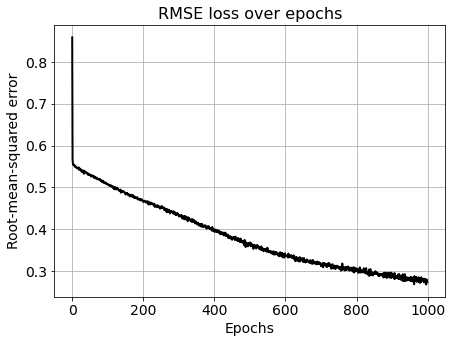

In [18]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(modelpepe_loss_mse['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# HASTA ACA ESTA LA DIFERENCIA DE LOS MODELOS

In [12]:
# Entrenando con los segundos valores

model.fit(trainX_list[1], trainY_list[1],
          epochs= num_epochs,
          batch_size = batch_size,
          callbacks= [MyCallback()],
          verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [13]:
model.save('model_segundo_entrenamiento.h5')

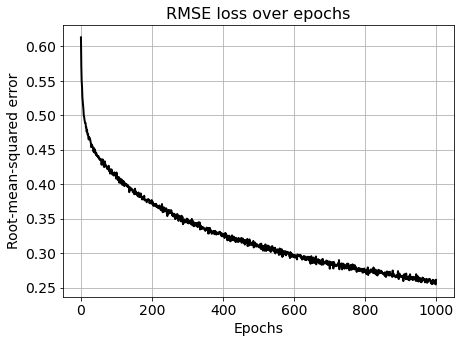

In [14]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [15]:
# Entrenando con los terceros valores

model.fit(trainX_list[2], trainY_list[2],
          epochs= num_epochs,
          batch_size = batch_size,
          callbacks= [MyCallback()],
          verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [16]:
model.save('model_tercer_entrenamiento.h5')

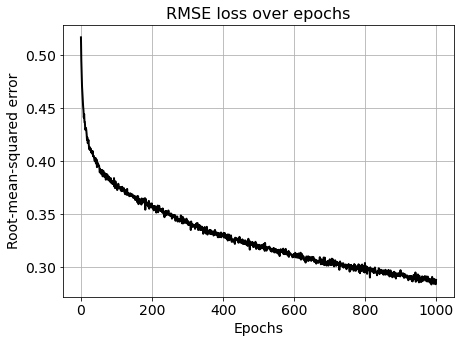

In [17]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [18]:
# Entrenando con los cuartos y últimos valores

model.fit(trainX_list[3], trainY_list[3],
          epochs= num_epochs,
          batch_size = batch_size,
          callbacks= [MyCallback()],
          verbose = 0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


In [19]:
model.save('model_cuarto_entrenamiento.h5')

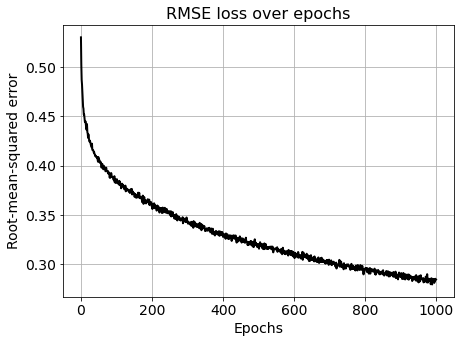

In [20]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k' ,lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Predicción

In [25]:
Tt

600

In [23]:
train_predict = model.predict(trainX_list[3])
test_predict = model.predict(testX_list[3])
prediccion_total = np.concatenate((train_predict, test_predict), axis=0)

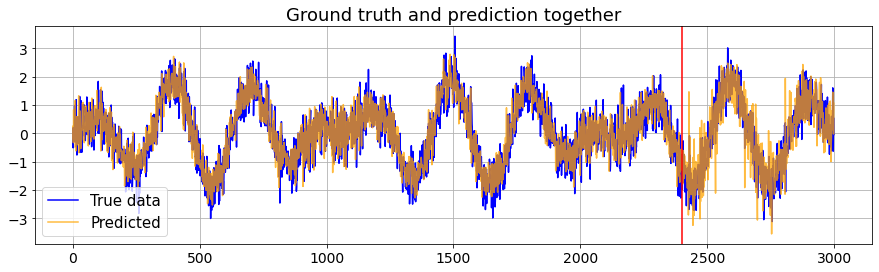

In [26]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index[0:Tp+Tt],df[0:Tp+Tt],c='blue')
plt.plot(index[0:Tp+Tt],prediccion_total,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()